In [1]:
import sys,os
PROJECT_ROOT=r"C:\Users\Matteo\Documents\projects\sdd\sdd_sports_scraper"
sys.path.insert(0, PROJECT_ROOT)
os.environ['PROJECT_ROOT']=PROJECT_ROOT
import pandas as pd
from common import sql_utils
from matplotlib import pyplot as plt
pd.options.display.max_columns=999
%matplotlib inline

ModuleNotFoundError: No module named 'common'

In [6]:
matchups=pd.read_sql("matchups",sql_utils.getConnection("nba"))
matchups

,away_3GA,away_3GM,away_A,away_BLK,away_Biggest Lead,away_DEF,away_FGA,away_FGM,away_FTA,away_FTM,away_Fast Break Pts,away_MIN,away_OFF,away_PF,away_PTS,away_Points in the Paint,away_STL,away_TO,away_TOT,away_name,game_datetime,game_id,game_type,home_3GA,home_3GM,home_A,home_BLK,home_Biggest Lead,home_DEF,home_FGA,home_FGM,home_FTA,home_FTM,home_Fast Break Pts,home_MIN,home_OFF,home_PF,home_PTS,home_Points in the Paint,home_STL,home_TO,home_TOT,home_line,home_name,over_under,season
0,20,9,20,2,5,25,82,38,14,13,10,240,15,26,98,40,7,13,40,BK,2011-12-30 19:30:00,837906,Regular Season,15,4,22,6,9,23,77,37,38,27,13,240,15,15,105,50,7,12,38,-11.5,ATL,177.0,2011-2012
1,25,6,17,4,8,33,80,32,21,14,5,240,12,18,84,28,3,11,45,BK,2012-03-23 19:30:00,838567,Regular Season,21,7,19,4,9,33,77,36,20,14,8,240,5,19,93,50,4,8,38,-7.0,ATL,188.0,2011-2012
2,16,6,21,6,15,34,74,29,17,15,10,240,6,23,79,20,9,16,40,BOS,2012-03-19 19:30:00,838536,Regular Season,15,5,15,2,8,36,75,29,19,13,8,240,9,19,76,26,5,17,45,-2.0,ATL,182.0,2011-2012
3,12,5,18,1,2,23,81,39,14,9,8,240,10,18,92,44,12,11,33,BOS,2012-04-20 19:00:00,838802,Regular Season,17,9,24,7,12,30,72,37,17,14,10,240,11,9,97,36,7,18,41,-10.5,ATL,180.0,2011-2012
4,11,0,21,3,0,34,82,32,13,10,11,240,7,24,74,36,9,6,41,BOS,2012-04-29 19:00:00,839996,Conference Quarterfinals,20,7,16,1,19,39,76,31,21,14,10,240,11,18,83,28,3,13,50,-1.0,ATL,179.0,2011-2012
5,14,3,14,6,9,42,68,29,31,26,20,240,3,24,87,26,6,14,45,BOS,2012-05-01 19:30:00,839997,Conference Quarterfinals,22,6,14,5,11,30,83,29,20,16,16,240,10,26,80,42,7,11,40,-4.5,ATL,172.5,2011-2012
6,14,6,23,3,10,24,77,34,15,12,12,240,9,13,86,38,11,14,33,BOS,2012-05-08 20:00:00,840000,Conference Quarterfinals,16,7,20,6,12,28,73,34,14,12,15,240,13,19,87,34,6,18,41,-1.5,ATL,175.5,2011-2012
7,8,1,21,6,0,26,78,33,16,14,10,240,4,19,81,38,3,12,30,CHA,2012-01-12 19:30:00,838018,Regular Season,19,6,29,4,30,35,90,42,28,21,24,240,20,16,111,52,8,9,55,-7.5,ATL,181.0,2011-2012
8,14,5,22,2,1,29,79,36,20,16,14,240,8,14,93,36,3,13,37,CHA,2012-04-04 19:30:00,838666,Regular Season,19,9,32,1,32,33,83,47,19,17,36,240,6,20,120,60,7,6,39,-13.0,ATL,185.5,2011-2012
9,14,6,21,5,0,26,82,36,20,16,17,240,17,9,94,48,8,19,43,CHI,2012-01-07 19:00:00,837974,Regular Season,12,9,32,8,29,27,83,47,6,6,27,240,4,16,109,54,16,13,31,6.0,ATL,174.5,2011-2012


In [2]:
!pwd

/mnt/c/Users/minim/projects/pythus/tutorials/Nate Silver ELO


In [7]:
full_df=pd.read_csv("nbaallelo.csv")
games=full_df[full_df['game_location']=='H'] #remove duplicated rows work with our elo implementation
games.head(1)

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,66,1300.0,1293.2767,40.29483,NYK,Knicks,68,1300.0,1306.7233,H,L,0.640065,NaN


In [8]:
games['SEASON']=games['year_id'].apply(lambda x: "%s-%s"%(x-1,x))

C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Nates Silver's NBA Elo Algorithm  
Single Season:  

$$R_{0}=1300$$

$$R_{i+1}=K(S_{team}-E_{team})R_i$$ where R is elo rating, $S$=1 if the team wins and $S=0$ for a loss. $E$ represents the expected win probability in Nate's formula and is defined as $$E_{\text{team}}=\frac{1}{1+10^{\frac{\text{opp_elo}-\text{team_elo}}{400}}}.$$ In chess K is a fixed constant but Nate changes K to handle margin of victory. Nate Silver's K is $$\text{K}=20\frac{(\text{MOV}_{winner}+3)^{0.8}}{7.5+0.006(\text{elo_difference}_{winner})}.$$ where $$\text{elo difference}_{winner}=\text{winning_elo}-\text{losing_elo}.$$ Nate also takes into account home advantage by increasing the rating of the home team by 100 as in $R_{\text{home}}=R_\text{team}+100$. 
The only other consideration is what to do in between seasons. Nate handles this by reverting each team towards a mean of 1505 as in the following formula $$R_{s=i+1}=(0.75)R_{s=i}+(0.25)1505.$$

In [9]:
import scipy.stats as st
from collections import defaultdict
import numpy as np

def silverK(MOV, elo_diff):
    K_0=20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return K_0*multiplier,K_0*multiplier

def silverS(home_score, away_score):
    S_home,S_away=0,0
    if home_score>away_score:
        S_home=1
    elif away_score>home_score:
        S_away=1
    else:
        S_home,S_away=.5,.5
    return S_home,S_away

def silver_elo_update(home_score, away_score, home_rating, away_rating):
    HOME_AD=100.
    home_rating+=HOME_AD
    E_home = elo_prediction(home_rating,away_rating)
    E_away=1-E_home
    elo_diff=home_rating-away_rating
    MOV=home_score-away_score
    
    S_home,S_away = silverS(home_score,away_score)
    if S_home>0:
        K_home,K_away =  silverK(MOV,elo_diff)
    else:
        K_home,K_away =  silverK(MOV,elo_diff)
        
    return K_home*(S_home-E_home),K_away*(S_away-E_away)

def elo_prediction(home_rating,away_rating):
    E_home = 1./(1 + 10 ** ((away_rating - home_rating) / (400.)))
    return E_home

def score_prediction(home_rating,away_rating):
    return (home_rating-away_rating)/28.

class HeadToHeadModel(object):
    def __init__(self, events, update_function, prediction_function=None):
        self.update_function=update_function
        self.events=events
        self.ratings={}
        self.prediction_function = prediction_function
        self.predictions = []
        self.curr_season=defaultdict(lambda: self.events[0][1]['year_id'])

    def train(self):
        for idx, event in self.events:
            new_year=event['year_id']
            label_i=event['fran_id']
            label_j=event['opp_fran']
            if self.ratings.get(label_i,False)==False:
                self.ratings[label_i]=elo_lookup(label_i,event['gameorder'])
            if self.ratings.get(label_j,False)==False:
                self.ratings[label_j]=elo_lookup(label_j,event['gameorder'])
                
            if self.curr_season[label_i]!=new_year:
                self.curr_season[label_i]=new_year
                self.ratings[label_i]=self.ratings[label_i]*.75+1505.*.25
            elif self.curr_season[label_j]!=new_year:
                self.curr_season[label_j]=new_year
                self.ratings[label_j]=self.ratings[label_j]*.75+1505.*.25
            #todo change below to just use event
            update=self.update_function(event['pts'],event['opp_pts'], self.ratings[label_i], self.ratings[label_j])
            self.ratings[label_i]+=update[0]
            self.ratings[label_j]+=update[1]
            

    def power_rankings(self):
        from operator import itemgetter
        power_rankings = sorted(self.ratings.items(), key=itemgetter(1), reverse=True)
        power = []
        for i, x in enumerate(power_rankings):
            power.append((i + 1, x))
        return power
    
STARTING_LOC=0
def elo_lookup(fran_id,gameorder):
    return full_df[(full_df['fran_id']==fran_id)&(full_df['gameorder']>=gameorder)]['elo_i'].iloc[0]
m=HeadToHeadModel(list(games[games['gameorder']>STARTING_LOC][:2].iterrows()), silver_elo_update, elo_prediction)
m.train()
m.power_rankings()

[(1, ('Stags', 1309.6521341903551)),
 (2, ('Knicks', 1297.0711425529637)),
 (3, ('Huskies', 1293.2767232566812))]

In [10]:
m=HeadToHeadModel(list(games[games['gameorder']>STARTING_LOC][:1].iterrows()), silver_elo_update, elo_prediction)
m.train()
m.power_rankings()

[(1, ('Knicks', 1306.7232767433188)), (2, ('Huskies', 1293.2767232566812))]

In [11]:
elo_lookup("Knicks",1)

1300.0

In [12]:
games

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes,SEASON
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,66,1300.0000,1293.2767,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN,1946-1947
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,63,1300.0000,1309.6521,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN,1946-1947
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,33,1300.0000,1279.6189,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN,1946-1947
7,4,194611020PRO,NBA,0,1947,11/2/1946,1,0,PRO,Steamrollers,59,1300.0000,1305.1542,41.540619,BOS,Celtics,53,1300.0000,1294.8458,H,W,0.640065,NaN,1946-1947
9,5,194611020STB,NBA,0,1947,11/2/1946,1,0,STB,Bombers,56,1300.0000,1304.6908,41.492020,PIT,Ironmen,51,1300.0000,1295.3092,H,W,0.640065,NaN,1946-1947
11,6,194611030CLR,NBA,0,1947,11/3/1946,1,0,CLR,Rebels,71,1300.0000,1307.1233,41.747120,TRH,Huskies,60,1293.2767,1286.1534,H,W,0.648932,NaN,1946-1947
12,7,194611040PIT,NBA,0,1947,11/4/1946,2,0,PIT,Ironmen,56,1295.3092,1277.9456,38.689037,WSC,Capitols,71,1320.3811,1337.7448,H,L,0.606189,NaN,1946-1947
14,8,194611050BOS,NBA,0,1947,11/5/1946,2,0,BOS,Celtics,55,1294.8458,1288.4139,39.785030,CHS,Stags,57,1309.6521,1316.0840,H,L,0.620204,NaN,1946-1947
17,9,194611050DTF,NBA,0,1947,11/5/1946,2,0,DTF,Falcons,49,1279.6189,1271.4624,38.011841,STB,Bombers,53,1304.6908,1312.8473,H,L,0.606189,NaN,1946-1947
19,10,194611070GSW,NBA,0,1947,11/7/1946,1,0,PHW,Warriors,81,1300.0000,1304.6670,41.489525,PIT,Ironmen,75,1277.9456,1273.2786,H,W,0.668764,NaN,1946-1947


In [13]:
full_df

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,66,1300.0000,1293.2767,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,68,1300.0000,1306.7233,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,63,1300.0000,1309.6521,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,47,1306.7233,1297.0712,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,33,1300.0000,1279.6189,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN
5,3,194611020DTF,NBA,1,1947,11/2/1946,1,0,WSC,Capitols,50,1300.0000,1320.3811,43.135952,DTF,Falcons,33,1300.0000,1279.6189,A,W,0.359935,NaN
6,4,194611020PRO,NBA,1,1947,11/2/1946,1,0,BOS,Celtics,53,1300.0000,1294.8458,40.459381,PRO,Steamrollers,59,1300.0000,1305.1542,A,L,0.359935,NaN
7,4,194611020PRO,NBA,0,1947,11/2/1946,1,0,PRO,Steamrollers,59,1300.0000,1305.1542,41.540619,BOS,Celtics,53,1300.0000,1294.8458,H,W,0.640065,NaN
8,5,194611020STB,NBA,1,1947,11/2/1946,1,0,PIT,Ironmen,51,1300.0000,1295.3092,40.507980,STB,Bombers,56,1300.0000,1304.6908,A,L,0.359935,NaN
9,5,194611020STB,NBA,0,1947,11/2/1946,1,0,STB,Bombers,56,1300.0000,1304.6908,41.492020,PIT,Ironmen,51,1300.0000,1295.3092,H,W,0.640065,NaN


Text(0.5, 1.0, "Comparison of Nate Silver's Elo and my Implementation")

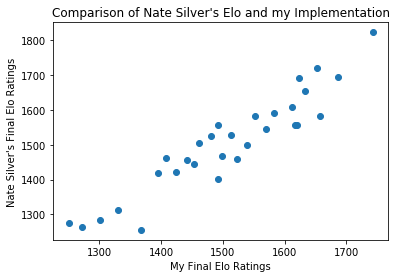

In [44]:
SSE=0
my_scores=[]
nate_scores=[]
for team,rating in m.ratings.items():
    nate_final_rating=full_df[full_df['fran_id']==team]['elo_n'].iloc[-1]
    my_scores.append(rating)
    nate_scores.append(nate_final_rating)
plt.scatter(my_scores, nate_scores)
plt.ylabel("Nate Silver's Final Elo Ratings")
plt.xlabel("My Final Elo Ratings")
plt.title("Comparison of Nate Silver's Elo and my Implementation")

In [16]:
import statsmodels.api as sm

X=my_scores
X=sm.add_constant(X)
Y=nate_scores
model=sm.OLS(Y,X)
results=model.fit()
results.summary()

C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\statsmodels\regression\linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\statsmodels\regression\linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\statsmodels\regression\linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Fri, 26 Jul 2019   Prob (F-statistic):                nan
Time:                        10:20:55   Log-Likelihood:                 47.686
No. Observations:                   2   AIC:                            -91.37
Df Residuals:                       0   BIC:                            -93.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3347.8036        inf         -0        nan         nan         nan
x1             3.5229        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.001
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.333
Skew:                           0.000   Prob(JB):                        0.846
Kurtosis:                       1.000   Cond. No.                     2.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Accuracy

## Win/Loss

In [17]:
class HeadToHeadModel(object):
    def __init__(self, events, update_function, prediction_function=None):
        self.update_function=update_function
        self.events=events
        self.ratings={}
        self.prediction_function = prediction_function
        self.predictions = []
        self.curr_season=defaultdict(lambda: self.events[0][1]['year_id'])

    def train(self):
        for idx, event in self.events:
            new_year=event['year_id']
            label_i=event['fran_id']
            label_j=event['opp_fran']
            if self.ratings.get(label_i,False)==False:
                self.ratings[label_i]=elo_lookup(label_i,event['gameorder'])
            if self.ratings.get(label_j,False)==False:
                self.ratings[label_j]=elo_lookup(label_j,event['gameorder'])
            
            if self.curr_season[label_i]!=new_year:
                self.curr_season[label_i]=new_year
                self.ratings[label_i]=self.ratings[label_i]*.75+1505.*.25
            elif self.curr_season[label_j]!=new_year:
                self.curr_season[label_j]=new_year
                self.ratings[label_j]=self.ratings[label_j]*.75+1505.*.25
            self.predictions.append(elo_prediction(self.ratings[label_i]+100, self.ratings[label_j]))
            #todo change below to just use event
            update=self.update_function(event['pts'],event['opp_pts'], self.ratings[label_i], self.ratings[label_j])
            self.ratings[label_i]+=update[0]
            self.ratings[label_j]+=update[1]
            

    def power_rankings(self):
        from operator import itemgetter
        power_rankings = sorted(self.ratings.items(), key=itemgetter(1), reverse=True)
        power = []
        for i, x in enumerate(power_rankings):
            power.append((i + 1, x))
        return power
STARTING_LOC=0
m=HeadToHeadModel(list(games[games['gameorder']>STARTING_LOC].iterrows()), silver_elo_update, elo_prediction)
m.train()
m.power_rankings()

[(1, ('Warriors', 1822.914895987812)),
 (2, ('Spurs', 1720.8001011280862)),
 (3, ('Clippers', 1694.1144220494582)),
 (4, ('Cavaliers', 1690.6400704479731)),
 (5, ('Rockets', 1653.7023930271428)),
 (6, ('Grizzlies', 1608.0398442899184)),
 (7, ('Bulls', 1590.3422517312054)),
 (8, ('Thunder', 1583.3325277657734)),
 (9, ('Hawks', 1580.8022609333432)),
 (10, ('Trailblazers', 1556.6176633083485)),
 (11, ('Mavericks', 1556.243142753922)),
 (12, ('Jazz', 1555.0967694610138)),
 (13, ('Colonels', 1551.8547371237116)),
 (14, ('Wizards', 1546.099743386566)),
 (15, ('Packers', 1537.424191789907)),
 (16, ('Pelicans', 1526.2895996053664)),
 (17, ('Celtics', 1524.5973756344547)),
 (18, ('Pacers', 1504.9709215762089)),
 (19, ('Raptors', 1500.2884071390527)),
 (20, ('Stags', 1490.9090883993758)),
 (21, ('Suns', 1466.6689096599282)),
 (22, ('Stars', 1463.7797493865216)),
 (23, ('Pistons', 1461.4225374545142)),
 (24, ('Nets', 1457.5564963016964)),
 (25, ('Heat', 1455.8896577081268)),
 (26, ('Spirits', 145

In [18]:
games['prediction']=m.predictions
games['predictedWinner']=games['prediction'].apply(lambda x: 1 if x>=.5 else 0)
games['winner']=games.apply(lambda x: x['pts']>=x['opp_pts'],axis=1)

C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Matteo\Anaconda3\envs\betting\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [19]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(games['winner'],games['predictedWinner'])
conf_matrix

array([[ 9772, 14061],
       [ 6083, 33222]], dtype=int64)

In [20]:
success_rate=np.trace(conf_matrix)/(np.sum(conf_matrix))
success_rate

0.6809528334758782

## Against the Spread (ATS)  
We only have spread data from 2011 onwards so we will change our starting location for this run.

In [21]:
class HeadToHeadModel(object):
    def __init__(self, events, update_function, prediction_function=None):
        self.update_function=update_function
        self.events=events
        self.ratings={}
        self.prediction_function = prediction_function
        self.predictions = []
        self.curr_season=defaultdict(lambda: self.events[0][1]['year_id'])

    def train(self):
        for idx, event in self.events:
            new_year=event['year_id']
            label_i=event['fran_id']
            label_j=event['opp_fran']
            if self.ratings.get(label_i,False)==False:
                self.ratings[label_i]=elo_lookup(label_i,event['gameorder'])
            if self.ratings.get(label_j,False)==False:
                self.ratings[label_j]=elo_lookup(label_j,event['gameorder'])
                
            if self.curr_season[label_i]!=new_year:
                self.curr_season[label_i]=new_year
                self.ratings[label_i]=self.ratings[label_i]*.75+1505.*.25
            elif self.curr_season[label_j]!=new_year:
                self.curr_season[label_j]=new_year
                self.ratings[label_j]=self.ratings[label_j]*.75+1505.*.25
            #todo change below to just use event
            self.predictions.append(score_prediction(self.ratings[label_i]+100, self.ratings[label_j]))
            update=self.update_function(event['pts'],event['opp_pts'], self.ratings[label_i], self.ratings[label_j])
            self.ratings[label_i]+=update[0]
            self.ratings[label_j]+=update[1]

    def power_rankings(self):
        from operator import itemgetter
        power_rankings = sorted(self.ratings.items(), key=itemgetter(1), reverse=True)
        power = []
        for i, x in enumerate(power_rankings):
            power.append((i + 1, x))
        return power

In [24]:
matchups.columns

Index(['away_3GA', 'away_3GM', 'away_A', 'away_BLK', 'away_Biggest Lead',
       'away_DEF', 'away_FGA', 'away_FGM', 'away_FTA', 'away_FTM',
       'away_Fast Break Pts', 'away_MIN', 'away_OFF', 'away_PF', 'away_PTS',
       'away_Points in the Paint', 'away_STL', 'away_TO', 'away_TOT',
       'away_name', 'game_datetime', 'game_id', 'game_type', 'home_3GA',
       'home_3GM', 'home_A', 'home_BLK', 'home_Biggest Lead', 'home_DEF',
       'home_FGA', 'home_FGM', 'home_FTA', 'home_FTM', 'home_Fast Break Pts',
       'home_MIN', 'home_OFF', 'home_PF', 'home_PTS',
       'home_Points in the Paint', 'home_STL', 'home_TO', 'home_TOT',
       'home_line', 'home_name', 'over_under', 'season'],
      dtype='object')

In [50]:
matchups.columns

Index(['away_3GA', 'away_3GM', 'away_A', 'away_BLK', 'away_Biggest Lead',
       'away_DEF', 'away_FGA', 'away_FGM', 'away_FTA', 'away_FTM',
       'away_Fast Break Pts', 'away_MIN', 'away_OFF', 'away_PF', 'away_PTS',
       'away_Points in the Paint', 'away_STL', 'away_TO', 'away_TOT',
       'away_name', 'game_datetime', 'game_id', 'game_type', 'home_3GA',
       'home_3GM', 'home_A', 'home_BLK', 'home_Biggest Lead', 'home_DEF',
       'home_FGA', 'home_FGM', 'home_FTA', 'home_FTM', 'home_Fast Break Pts',
       'home_MIN', 'home_OFF', 'home_PF', 'home_PTS',
       'home_Points in the Paint', 'home_STL', 'home_TO', 'home_TOT',
       'home_line', 'home_name', 'over_under', 'season'],
      dtype='object')

In [49]:
games['SEASON'].unique()

array(['1946-1947', '1947-1948', '1948-1949', '1949-1950', '1950-1951',
       '1951-1952', '1952-1953', '1953-1954', '1954-1955', '1955-1956',
       '1956-1957', '1957-1958', '1958-1959', '1959-1960', '1960-1961',
       '1961-1962', '1962-1963', '1963-1964', '1964-1965', '1965-1966',
       '1966-1967', '1967-1968', '1968-1969', '1969-1970', '1970-1971',
       '1971-1972', '1972-1973', '1973-1974', '1974-1975', '1975-1976',
       '1976-1977', '1977-1978', '1978-1979', '1979-1980', '1980-1981',
       '1981-1982', '1982-1983', '1983-1984', '1984-1985', '1985-1986',
       '1986-1987', '1987-1988', '1988-1989', '1989-1990', '1990-1991',
       '1991-1992', '1992-1993', '1993-1994', '1994-1995', '1995-1996',
       '1996-1997', '1997-1998', '1998-1999', '1999-2000', '2000-2001',
       '2001-2002', '2002-2003', '2003-2004', '2004-2005', '2005-2006',
       '2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011',
       '2011-2012', '2012-2013', '2013-2014', '2014-2015'], dtyp

In [51]:
matchups['game_id']=matchups.apply(lambda x: x['game_datetime'].split(" ")[0].replace("-","")+"0"+x['home_name'],axis=1)
games_w_odds=matchups.merge(games)
games_w_odds.tail(1)

,away_3GA,away_3GM,away_A,away_BLK,away_Biggest Lead,away_DEF,away_FGA,away_FGM,away_FTA,away_FTM,away_Fast Break Pts,away_MIN,away_OFF,away_PF,away_PTS,away_Points in the Paint,away_STL,away_TO,away_TOT,away_name,game_datetime,game_id,game_type,home_3GA,home_3GM,home_A,home_BLK,home_Biggest Lead,home_DEF,home_FGA,home_FGM,home_FTA,home_FTM,home_Fast Break Pts,home_MIN,home_OFF,home_PF,home_PTS,home_Points in the Paint,home_STL,home_TO,home_TOT,home_line,home_name,over_under,season
7675,35,15,25,6,7,37,93,43,19,14,19,240,11,28,115,44,6,17,48,PHI,2017-10-18 19:00:00,201710180WAS,Regular Season,22,6,21,10,12,36,97,42,38,30,4,240,16,20,120,50,8,9,52,-6.5,WAS,217.5,2017-2018


In [52]:
m=HeadToHeadModel(list(games_w_odds.iterrows()), silver_elo_update, elo_prediction)
m.train()
m.power_rankings()

KeyError: 'year_id'

In [28]:
games_w_odds['predictedHomeMOV']=m.predictions
games_w_odds['homeMOV']=games_w_odds['pts']-games_w_odds['opp_pts']
games_w_odds['homeCover']=(games_w_odds['homeMOV']+games_w_odds['home_line'])>0
games_w_odds.head(1)

,away_3GA,away_3GM,away_A,away_BLK,away_Biggest Lead,away_DEF,away_FGA,away_FGM,away_FTA,away_FTM,away_Fast Break Pts,away_MIN,away_OFF,away_PF,away_PTS,away_Points in the Paint,away_STL,away_TO,away_TOT,away_name,game_datetime,game_id,game_type,home_3GA,home_3GM,home_A,home_BLK,home_Biggest Lead,home_DEF,home_FGA,home_FGM,home_FTA,home_FTM,home_Fast Break Pts,home_MIN,home_OFF,home_PF,home_PTS,home_Points in the Paint,home_STL,home_TO,home_TOT,home_line,home_name,over_under,season,gameorder,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes,SEASON,prediction,predictedWinner,winner,predictedHomeMOV,homeMOV,homeCover
0,20,9,20,2,5,25,82,38,14,13,10,240,15,26,98,40,7,13,40,BK,2011-12-30 19:30:00,201112300ATL,Regular Season,15,4,22,6,9,23,77,37,38,27,13,240,15,15,105,50,7,12,38,-11.5,ATL,177.0,2011-2012,58178,NBA,0,2012,12/30/2011,3,0,ATL,Hawks,105,1515.991,1518.3048,42.50956,NJN,Nets,98,1338.1683,1335.8545,H,W,0.831917,NaN,2011-2012,0.833801,1,True,9.922239,7,False


In [29]:
len(games_w_odds)

4105

In [30]:
games_w_odds['SEASON'].unique()

array(['2011-2012', '2012-2013', '2013-2014', '2014-2015'], dtype=object)

In [38]:
from sklearn.metrics import accuracy_score

In [41]:
def bettingFunction(row):
    '''
    if algo favors team more than vegas predicted score bet for, True. Else bet for the team True
    '''
    return (row['predictedHomeMOV']+row['home_line'])>0
games_w_odds['bets']=games_w_odds.apply(bettingFunction,axis=1)
for season, data in games_w_odds.groupby("season"):
    print(season)
    conf_matrix=confusion_matrix(data['homeCover'],data['bets'])
    print(accuracy_score(data['homeCover'],data['bets']))
    display(pd.DataFrame(conf_matrix, columns=["Bet on Away","Bet on Home"], index=["Away Covers","Home Covers"]))
    
    print("____________________")
    
conf_matrix=confusion_matrix(games_w_odds['homeCover'],games_w_odds['bets'])
pd.DataFrame(conf_matrix, columns=["Bet on Away","Bet on Home"], index=["Away Covers","Home Covers"])
    

2011-2012
0.5211581291759465


,Bet on Away,Bet on Home
Away Covers,234,223
Home Covers,207,234


____________________
2012-2013
0.5300647548566142


,Bet on Away,Bet on Home
Away Covers,299,257
Home Covers,251,274


____________________
2013-2014
0.5201834862385321


,Bet on Away,Bet on Home
Away Covers,287,303
Home Covers,220,280


____________________
2014-2015
0.5154440154440154


,Bet on Away,Bet on Home
Away Covers,282,269
Home Covers,233,252


____________________


,Bet on Away,Bet on Home
Away Covers,1102,1052
Home Covers,911,1040


In [33]:
print(pd.DataFrame(conf_matrix, columns=["Bet on Away","Bet on Home"], index=["Away Covers","Home Covers"]).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Bet on Away</th>
      <th>Bet on Home</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Away Covers</th>
      <td>1102</td>
      <td>1052</td>
    </tr>
    <tr>
      <th>Home Covers</th>
      <td>911</td>
      <td>1040</td>
    </tr>
  </tbody>
</table>


In [34]:
success_rate=np.trace(conf_matrix)/(np.sum(conf_matrix))
success_rate

0.5218026796589526

### Analysis of Error Profile  
Although the expected value is no better than a coin flip there could be an advantage in terms of the error profile

In [35]:
bets=np.random.binomial(1,.5,len(games_w_odds))
truths=np.random.binomial(1,.5,len(games_w_odds))
conf_matrix=confusion_matrix(truths,bets)
pd.DataFrame(conf_matrix, columns=["Bet on Away","Bet on Home"], index=["Away Covers","Home Covers"])

,Bet on Away,Bet on Home
Away Covers,1093,988
Home Covers,1056,968


In [135]:
pd.DataFrame(conf_matrix, columns=["Bet on Away","Bet on Home"], index=["Away Covers","Home Covers"]).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Bet on Away</th>\n      <th>Bet on Home</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Away Covers</th>\n      <td>812</td>\n      <td>796</td>\n    </tr>\n    <tr>\n      <th>Home Covers</th>\n      <td>783</td>\n      <td>825</td>\n    </tr>\n  </tbody>\n</table>'